# **Amazon Lookout for Equipment** - Getting started
*Part 1 - Data preparation*

## Initialization
---
This repository is structured as follow:

```sh
. lookout-equipment-demo
|
├── data/
|   ├── interim                          # Temporary intermediate data are stored here
|   ├── processed                        # Finalized datasets are usually stored here
|   |                                    # before they are sent to S3 to allow the
|   |                                    # service to reach them
|   └── raw                              # Immutable original data are stored here
|
├── getting_started/
|   ├── 1_data_preparation.ipynb         <<< THIS NOTEBOOK <<<
|   ├── 2_dataset_creation.ipynb
|   ├── 3_model_training.ipynb
|   ├── 4_model_evaluation.ipynb
|   ├── 5_inference_scheduling.ipynb
|   └── 6_cleanup.ipynb
|
└── utils/
    └── lookout_equipment_utils.py
```

### Notebook configuration update

In [1]:
!pip install --quiet --upgrade tqdm tsia

### Imports

In [1]:
import boto3
import config
import os
import pandas as pd

from botocore.client import ClientError

Check the region and the availability of Amazon Lookout for Equipment in this region:

In [2]:
REGION_NAME = boto3.session.Session().region_name

try:
    ssm_client = boto3.client('ssm')
    response = ssm_client.get_parameters_by_path(
        Path='/aws/service/global-infrastructure/services/lookoutequipment/regions',
    )

    available_regions = [r['Value'] for r in response['Parameters']]
    if REGION_NAME not in available_regions:
        raise Exception(f'Amazon Lookout for Equipment is only available in {available_regions}')
        
except ClientError as e:
    print(f'This notebook does not have access to the SSM service to check the availability of Lookout for Equipment in the current region ({REGION_NAME}).')
    print(f'If you are running this code in the following AWS region, it should be fine to continue: us-east-1, ap-northeast-2, eu-west-1')
    print('Exception:')
    print(' -', e)

This notebook does not have access to the SSM service to check the availability of Lookout for Equipment in the current region (eu-west-1).
If you are running this code in the following AWS region, it should be fine to continue: us-east-1, ap-northeast-2, eu-west-1
Exception:
 - An error occurred (AccessDeniedException) when calling the GetParametersByPath operation: User: arn:aws:sts::123031033346:assumed-role/AmazonSageMaker-ExecutionRole-20200922T205159/SageMaker is not authorized to perform: ssm:GetParametersByPath on resource: arn:aws:ssm:eu-west-1::parameter/aws/service/global-infrastructure/services/lookoutequipment/regions because no identity-based policy allows the ssm:GetParametersByPath action


### Parameters
Let's first check if the bucket name is defined, if it exists and if we have access to it from this notebook. If this notebook does not have access to the S3 bucket, you will have to update its permission:

In [3]:
BUCKET           = config.BUCKET
PREFIX_TRAINING  = config.PREFIX_TRAINING
PREFIX_LABEL     = config.PREFIX_LABEL

if BUCKET == '<<YOUR_BUCKET>>':
    raise Exception('Please update your Amazon S3 bucket name in the config.py file located at the root of this repository and restart the kernel for this notebook.')
    
else:
    # Check access to the configured bucket:
    try:
        s3_resource = boto3.resource('s3')
        s3_resource.meta.client.head_bucket(Bucket=BUCKET)
        print(f'Bucket "{BUCKET}" exists')
        
    # Expose error reason:
    except ClientError as error:
        error_code = int(error.response['Error']['Code'])
        if error_code == 403:
            raise Exception(f'Bucket "{BUCKET}" is private: access is forbidden!')
            
        elif error_code == 404:
            raise Exception(f'Bucket "{BUCKET}" does not exist!')

Bucket "lookout-equipment-getting-started" exists


In [4]:
RAW_DATA       = os.path.join('..', 'data', 'raw', 'getting-started')
TMP_DATA       = os.path.join('..', 'data', 'interim', 'getting-started')
PROCESSED_DATA = os.path.join('..', 'data', 'processed', 'getting-started')
LABEL_DATA     = os.path.join(PROCESSED_DATA, 'label-data')
TRAIN_DATA     = os.path.join(PROCESSED_DATA, 'training-data')
INFERENCE_DATA = os.path.join(PROCESSED_DATA, 'inference-data')

os.makedirs(TMP_DATA,         exist_ok=True)
os.makedirs(RAW_DATA,         exist_ok=True)
os.makedirs(PROCESSED_DATA,   exist_ok=True)
os.makedirs(LABEL_DATA,       exist_ok=True)
os.makedirs(TRAIN_DATA,       exist_ok=True)
os.makedirs(INFERENCE_DATA,   exist_ok=True)

ORIGINAL_DATA = f's3://lookoutforequipmentbucket-{REGION_NAME}/datasets/getting-started/lookout-equipment-sdk-5min.zip'

## Downloading data
---
Downloading and unzipping the getting started dataset locally on this instance:

In [5]:
data_exists = os.path.exists(os.path.join(TMP_DATA, 'sensors-data', 'impeller', 'component2_file1.csv'))
raw_data_exists = os.path.exists(os.path.join(RAW_DATA, 'lookout-equipment.zip'))

if data_exists:
    print('Dataset already available locally, nothing to do.')
    print(f'Dataset is available in {TMP_DATA}.')
    
else:
    if not raw_data_exists:
        print('Raw data not found, downloading it')
        !aws s3 cp $ORIGINAL_DATA $RAW_DATA/lookout-equipment.zip
        
    print('Unzipping raw data...')
    !unzip $RAW_DATA/lookout-equipment.zip -d $TMP_DATA
    print(f'Done: dataset now available in {TMP_DATA}.')

Dataset already available locally, nothing to do.
Dataset is available in ../data/interim/getting-started.


## Preparing time series data
---
The time series data are available in the `sensors-data` directory. The industrial asset we are looking at is a [centrifugal pump](https://en.wikipedia.org/wiki/Centrifugal_pump). Such a pump is used to move a fluid by transfering the rotational energy provided by a motor to hydrodynamic energy:

<img src="assets/centrifugal_pump_annotated.png" alt="Centrifugal pump" style="width: 658px"/>

<div style="text-align: center"><i>Warman centrifugal pump in a coal preparation plant application</i>, by Bernard S. Janse, licensed under <a href="https://creativecommons.org/licenses/by/2.5/deed.fr">CC BY 2.5</a></div>

On a pump such as the one displayed in the photo above, the fluid enters at its axis (the black pipe arriving at the "eye" of the impeller. Measurements can be taken around the four main components of the centrifugal pump:
* The **impeller** (hidden into the round white casing above): this component consists of a series of curved vanes (blades)
* The drive **shaft** arriving at the impeller axis (the "eye")
* The **motor** connected to the impeller by the drive shaft (on the other end of the black pipe above)
* The **volute** chamber, offseted on the right compared to the impeller axis: this creates a curved funnel win a decreasing cross-section area towards the pump outlet (at the top of the white pipe above)

In the dataset provided, other sensors not located on one of these component are positionned at the **pump** level.

**Let's load the content of each CSV file (we have one per component) and build a single CSV file with all the sensors:** we will obtain a dataset with 10 months of data (spanning from `2019-01-01` to `2019-10-27`) for 30 sensors (`Sensor0` to `Sensor29`) with a 1-minute sampling rate:

In [6]:
%%time

# Loops through each subfolder of the original dataset:
sensor_df_list = []
tags_description_dict = dict()
for root, dirs, files in os.walk(os.path.join(TMP_DATA, 'sensors-data')):
    # Reads each file and set the first column as an index:
    for f in files:
        print('Processing:', os.path.join(root, f))
        df = pd.read_csv(os.path.join(root, f))
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df = df.set_index('Timestamp')
        sensor_df_list.append(df)
        
        component = root.split('/')[-1]
        current_sensors = df.columns.tolist()
        current_sensors = dict(zip(current_sensors, [component] * len(current_sensors)))
        tags_description_dict = {**tags_description_dict, **current_sensors}
        
# Concatenate into a single dataframe:
equipment_df = pd.concat(sensor_df_list, axis='columns')
equipment_df = equipment_df.reset_index()
equipment_df['Timestamp'] = pd.to_datetime(equipment_df['Timestamp'])
equipment_df = equipment_df[[
    'Timestamp', 'Sensor0', 'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4',
    'Sensor5', 'Sensor6', 'Sensor7', 'Sensor8', 'Sensor9', 'Sensor10',
    'Sensor11', 'Sensor24', 'Sensor25', 'Sensor26', 'Sensor27', 'Sensor28',
    'Sensor29', 'Sensor12', 'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16',
    'Sensor17', 'Sensor18', 'Sensor19', 'Sensor20', 'Sensor21', 'Sensor22',
    'Sensor23'
]]

# Register a component for each sensor:
tags_description_df = pd.DataFrame.from_dict(tags_description_dict, orient='index')
tags_description_df = tags_description_df.reset_index()
tags_description_df.columns = ['Tag', 'Component']

print(equipment_df.shape)
equipment_df.head()

Processing: ../data/interim/getting-started/sensors-data/pump/component1_file1.csv
Processing: ../data/interim/getting-started/sensors-data/impeller/component2_file1.csv
Processing: ../data/interim/getting-started/sensors-data/shaft/component5_file1.csv
Processing: ../data/interim/getting-started/sensors-data/motor/component3_file1.csv
Processing: ../data/interim/getting-started/sensors-data/volute/component4_file1.csv
(86400, 31)
CPU times: user 647 ms, sys: 107 ms, total: 755 ms
Wall time: 2.36 s


,Timestamp,Sensor0,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,...,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,Sensor22,Sensor23
0,2019-01-01 00:00:00,-0.828743,-0.068548,0.151633,-0.194587,0.862565,0.380223,6.852690,6.299292,7.219419,...,0.515517,0.565051,1.034995,1.296515,0.452947,0.548628,0.789443,0.863054,0.923071,0.973008
1,2019-01-01 00:05:00,0.019142,-0.946242,0.580651,-0.155384,0.116038,-0.185083,6.720679,7.688384,6.779484,...,0.637117,0.996548,0.493391,0.725938,0.896024,0.854002,0.600282,0.516597,0.192187,0.078018
2,2019-01-01 00:10:00,-0.036186,0.206872,0.343356,0.083626,-0.342867,-0.461456,7.581135,7.061488,6.230064,...,0.693980,0.287831,0.757481,1.254490,-0.040230,-0.229816,-0.488845,-0.712760,-0.752211,-0.933826
3,2019-01-01 00:15:00,-0.550611,-0.301188,0.148512,0.051228,-0.385147,-0.008690,7.486352,7.303732,6.881112,...,0.710251,1.224501,1.212985,1.196189,-0.918477,-0.968557,-0.881842,-0.860428,-0.714133,-0.515620
4,2019-01-01 00:20:00,-0.606425,-0.331560,-0.093932,0.784581,0.256889,-1.209056,7.010256,6.758775,7.089719,...,0.636829,0.845588,0.951010,2.279935,-0.460253,-0.338305,-0.064312,0.254336,0.443540,0.634771


In [7]:
equipment_df['Timestamp'] = pd.to_datetime(equipment_df['Timestamp'])
equipment_df = equipment_df.set_index('Timestamp')
equipment_df

,Sensor0,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor9,...,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,Sensor22,Sensor23
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.828743,-0.068548,0.151633,-0.194587,0.862565,0.380223,6.852690,6.299292,7.219419,7.004522,...,0.515517,0.565051,1.034995,1.296515,0.452947,0.548628,0.789443,0.863054,0.923071,0.973008
2019-01-01 00:05:00,0.019142,-0.946242,0.580651,-0.155384,0.116038,-0.185083,6.720679,7.688384,6.779484,6.979925,...,0.637117,0.996548,0.493391,0.725938,0.896024,0.854002,0.600282,0.516597,0.192187,0.078018
2019-01-01 00:10:00,-0.036186,0.206872,0.343356,0.083626,-0.342867,-0.461456,7.581135,7.061488,6.230064,6.859606,...,0.693980,0.287831,0.757481,1.254490,-0.040230,-0.229816,-0.488845,-0.712760,-0.752211,-0.933826
2019-01-01 00:15:00,-0.550611,-0.301188,0.148512,0.051228,-0.385147,-0.008690,7.486352,7.303732,6.881112,6.877079,...,0.710251,1.224501,1.212985,1.196189,-0.918477,-0.968557,-0.881842,-0.860428,-0.714133,-0.515620
2019-01-01 00:20:00,-0.606425,-0.331560,-0.093932,0.784581,0.256889,-1.209056,7.010256,6.758775,7.089719,6.988612,...,0.636829,0.845588,0.951010,2.279935,-0.460253,-0.338305,-0.064312,0.254336,0.443540,0.634771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27 23:35:00,0.572524,0.831853,0.012117,-0.170698,-0.468361,-0.938305,7.014236,6.712674,7.047559,7.205919,...,0.587945,1.357115,0.408277,0.454207,0.297795,0.437233,0.713052,0.802132,0.857221,0.850883
2019-10-27 23:40:00,0.100300,0.808269,-0.956786,0.374711,-1.346233,-0.949926,7.621383,6.781719,6.918772,7.916911,...,0.772307,1.976682,0.557193,1.073810,0.952974,0.911620,0.774939,0.702791,0.425559,0.176686
2019-10-27 23:45:00,-0.315199,0.077039,0.043951,-0.605731,1.199912,0.247149,7.405565,7.736269,6.358986,6.946860,...,1.280365,1.085853,1.077586,1.017124,0.256050,-0.012063,-0.231324,-0.513373,-0.566445,-0.779766


In [8]:
%%time

os.makedirs(os.path.join(TRAIN_DATA, 'centrifugal-pump'), exist_ok=True)
equipment_fname = os.path.join(TRAIN_DATA, 'centrifugal-pump', 'sensors.csv')
equipment_df.to_csv(equipment_fname)

CPU times: user 3.78 s, sys: 46.2 ms, total: 3.82 s
Wall time: 4.56 s


Let's also persist the tags description file as it will be useful when analyzing the model results:

In [9]:
tags_description_fname = os.path.join(TMP_DATA, 'tags_description.csv')
tags_description_df.to_csv(tags_description_fname, index=None)

## Loading label data
---
This dataset contains synthetically generated anomalies over different periods of time. Labels are stored as time ranges with a start and end timestamp. Each label is a period of time where we know some anomalous behavior happen:

In [10]:
label_fname = os.path.join(TMP_DATA, 'label-data', 'labels.csv')
labels_df = pd.read_csv(label_fname, header=None)
labels_df.to_csv(os.path.join(PROCESSED_DATA, 'label-data', 'labels.csv'), index=None, header=None)
labels_df.columns = ['start', 'end']
labels_df.head()

,start,end
0,2019-01-10 00:00:00,2019-01-11 00:00:00
1,2019-01-20 00:00:00,2019-01-21 00:00:00
2,2019-01-30 00:00:00,2019-01-31 00:00:00
3,2019-02-09 00:00:00,2019-02-10 00:00:00
4,2019-02-19 00:00:00,2019-02-20 00:00:00


## Uploading data to Amazon S3
---
Let's now load our training data and labels to Amazon S3, so that Lookout for Equipment can access them to train and evaluate a model.

In [11]:
train_s3_path = f's3://{BUCKET}/{PREFIX_TRAINING}centrifugal-pump/sensors.csv'
!aws s3 cp $equipment_fname $train_s3_path

label_s3_path = f's3://{BUCKET}/{PREFIX_LABEL}labels.csv'
!aws s3 cp $label_fname $label_s3_path

upload: ../data/processed/getting-started/training-data/centrifugal-pump/sensors.csv to s3://lookout-equipment-getting-started/getting_started/training-data/centrifugal-pump/sensors.csv
upload: ../data/interim/getting-started/label-data/labels.csv to s3://lookout-equipment-getting-started/getting_started/label-data/labels.csv


## (Optional) Data exploration
---
This section is optional and just aim at giving you a quick overview about what the data looks like:

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import tsia
import warnings

sys.path.append('../utils')
import lookout_equipment_utils as lookout

%matplotlib inline
plt.style.use('Solarize_Light2')
plt.rcParams['lines.linewidth'] = 0.5
warnings.filterwarnings("ignore")

In [13]:
start = equipment_df.index.min()
end = equipment_df.index.max()

print(start, '|', end)

2019-01-01 00:00:00 | 2019-10-27 23:55:00


**Let's plot the first signal and the associated labels:** the `plot_timeseries` function is a utility function you can use to plot a signal and the associated labels on the same figure:

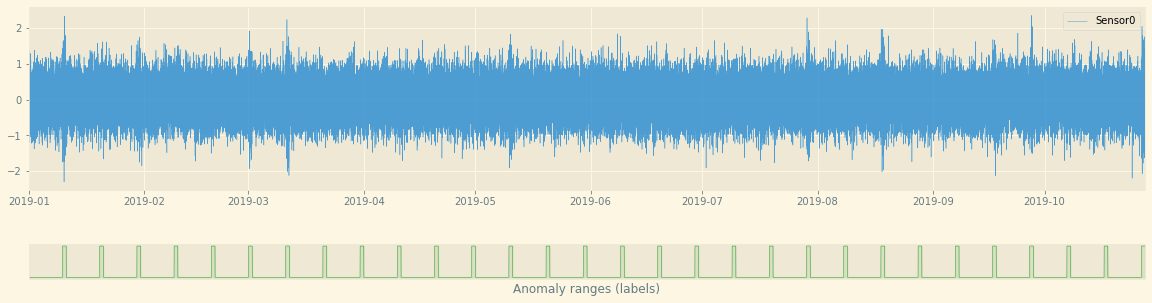

In [14]:
tag = 'Sensor0'
tag_df = equipment_df.loc[start:end, [tag]]
tag_df.columns = ['Value']

fig1, axes = lookout.plot_timeseries(
    tag_df, 
    tag, 
    fig_width=20, 
    labels_df=labels_df,
    custom_grid=False
)

**Run the following cell to get an overview of every signals in the dataset:** colors are allocated to each sensor according to the component it's associated to. This generates a big matplotlib picture in memory. On smaller instances, this can lead to some *out of memory* issues. Upgrade to a bigger instance, or clean up the memory of the instances if you have other notebooks running in parallel to this one:

100%|██████████| 30/30 [00:00<00:00, 43.72it/s]


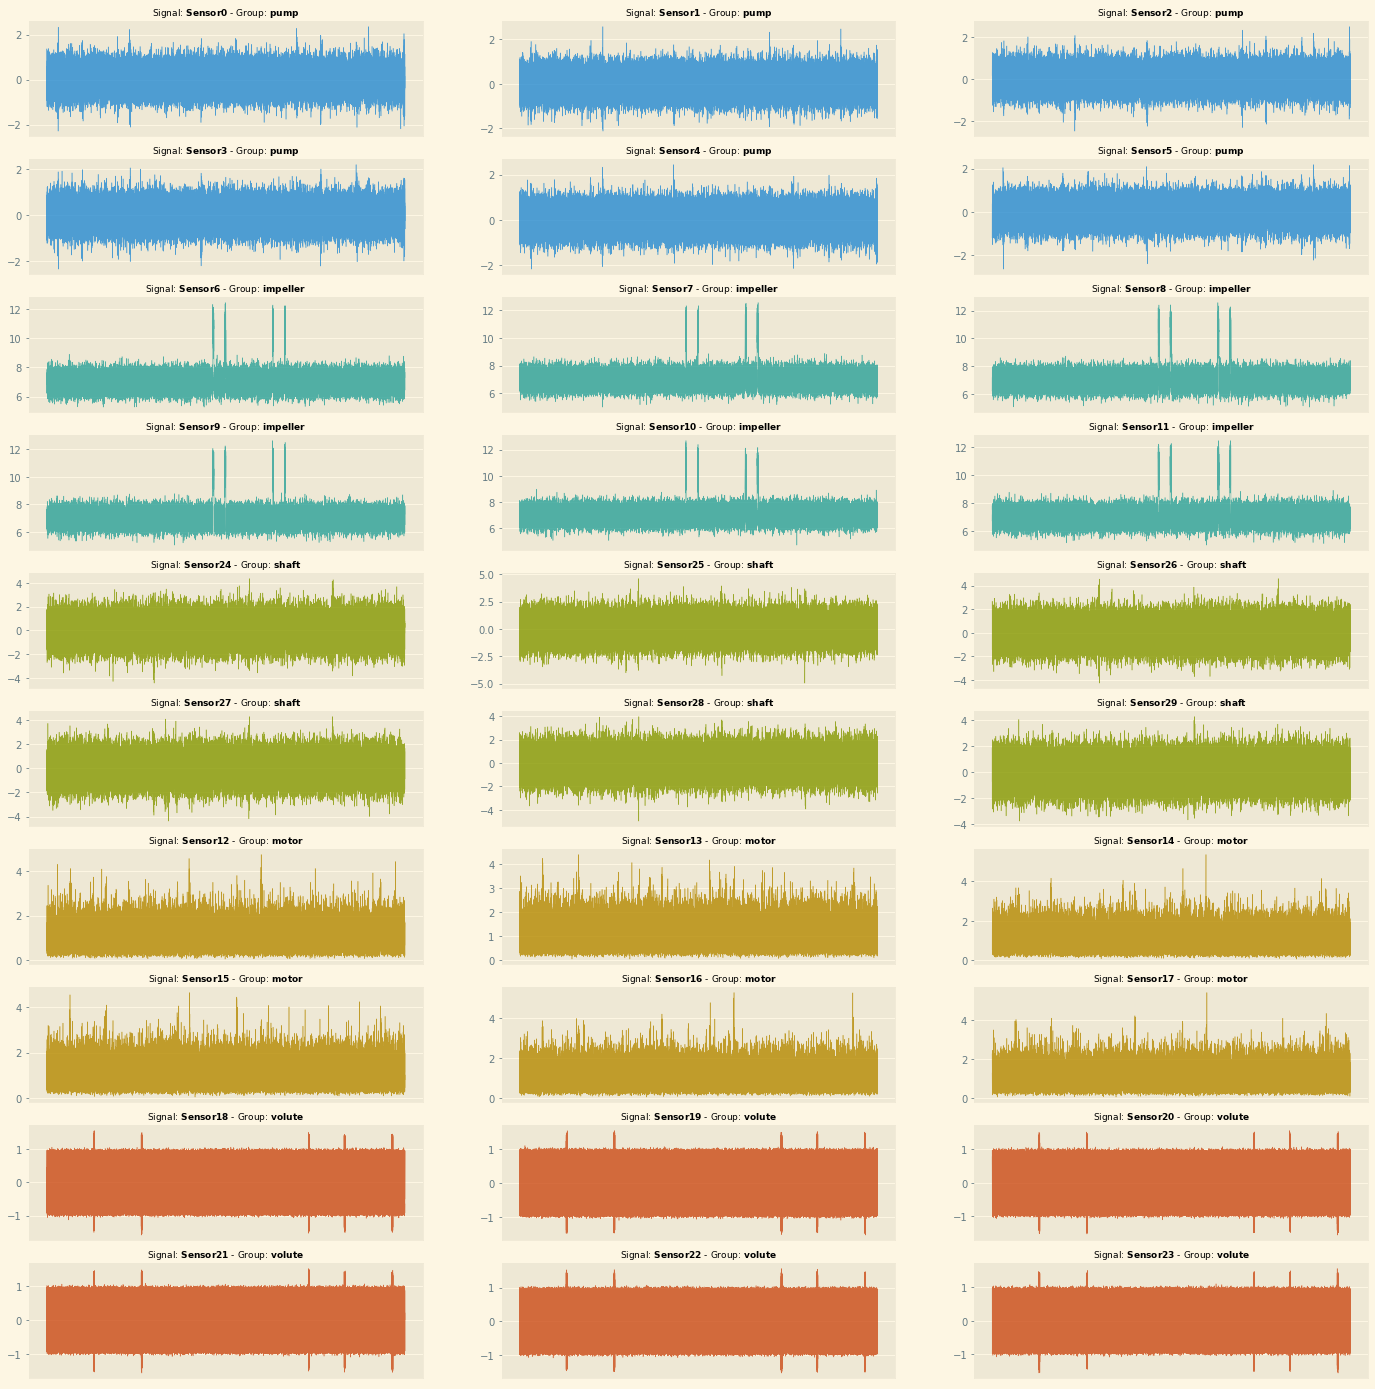

In [15]:
df_list = []
features = equipment_df.columns.tolist()
for sensor in features:
    df_list.append(equipment_df[[sensor]])
    
fig2 = tsia.plot.plot_multivariate_timeseries(
    timeseries_list=df_list,
    tags_list=features,
    tags_description_df=tags_description_df,
    tags_grouping_key='Component',
    num_cols=3,
)

## Conclusion
---
In this notebook, you downloaded the getting started dataset and prepared it for ingestion in Amazon Lookout for Equipment.

You also had a quick overview of the dataset with basic timeseries visualization.

You uploaded the training time series data and the anomaly labels to Amazon S3: in the next notebook of this getting started, you will be acquainted with the Amazon Lookout for Equipment API to create your first dataset.

In [16]:
# Cleanup, might be necessary on smaller instances:
import gc
del fig1, fig2, equipment_df
gc.collect()

74423